### Chapter 18
**CH18B Forecasting a home price index**

using case-schiller-la dataset

version 1.1 2024-01-11

In [2]:
!pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/ac/f8/6c9364602b13f0dba129b53acd1344859690911a4d5021560d9fd6aa087f/pmdarima-2.0.4-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for Cython!=0.29.18,!=0.29.31,>=0.29 from https://files.pythonhosted.org/packages/85/7d/58635941dfbb5b4e197adb88080b9cbfb230dc3b75683698a530a1989bdb/Cython-3.0.8-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
   --------------------------- ------------ 430.1/614.7 kB 8.9 MB/s eta 0:00:01
   ---------------------------------------- 614.7/614.7 kB 7.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   -------- ------------------------------- 0.6/2.8 MB 18.5 MB/s eta 0:00:01
   -------------- ------------------------- 1.0/2.8 MB 10.7 MB/s eta 0:00:01
   -------------------- --

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


In [3]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import statsmodels
import patsy
from pmdarima.arima import auto_arima
import statsmodels.formula.api as smf
import warnings
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

In [4]:
%matplotlib inline

### Get Data

In [5]:
# Current script and repository folder
current_path = os.getcwd()
repository_path = current_path.split('Ch18')[0]

In [6]:
# Add utils folder to sys path 
# Note: os.path.join() creates a string with the right syntax for defining a path for your operating sytem.
sys.path.append(os.path.join(repository_path, 'utils'))

In [7]:
# Define data folder
data_path = os.path.join(repository_path, 'data')

In [8]:
# Import the prewritten helper functions
from py_helper_functions import *

In [9]:
# DATA IMPORT - FROM GITHUB
data = pd.read_csv('https://raw.githubusercontent.com/peterduronelly/DA3-Python-Codes/main/data/homeprices-data-2000-2018.csv')

In [10]:
data.head()

,date,year,month,ps,pn,us,un,emps,empn
0,2000-01-01,2000,1,101.031209,100.00000,5.0,5.4,14344.4,14132.8
1,2000-02-01,2000,2,102.043406,100.61896,5.0,5.3,14390.4,14270.0
2,2000-03-01,2000,3,103.224699,102.12780,5.0,5.3,14429.1,14421.3
3,2000-04-01,2000,4,104.159399,103.70410,5.0,4.7,14484.6,14450.8
4,2000-05-01,2000,5,104.924698,104.98908,5.0,4.7,14549.9,14590.2


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    228 non-null    object 
 1   year    228 non-null    int64  
 2   month   228 non-null    int64  
 3   ps      228 non-null    float64
 4   pn      228 non-null    float64
 5   us      228 non-null    float64
 6   un      228 non-null    float64
 7   emps    228 non-null    float64
 8   empn    228 non-null    float64
dtypes: float64(6), int64(2), object(1)
memory usage: 16.2+ KB


### EDA

In [12]:
data = data.assign(date=lambda x: x.date.str[0:7])
data = data.rename({"pn": "p", "us": "u", "emps": "emp"}, axis=1)

In [13]:
data.sort_values(by=["date"], inplace= True)

In [14]:
data['dp'] = data.p.diff(1)
data['p_lag'] = data.p.shift(1)
data['lnp'] = np.log(data.p)
data['dlnp'] = data.lnp.diff(1)
data['lnp_lag'] = data.lnp.shift(1)
data['dlnp_lag'] = data.dlnp.shift(1)
data['du'] = data.u.diff(1)
data['lnemp'] = np.log(data.emp)
data['dlnemp'] = data.lnemp.diff(1)
data['trend'] = range(1, data.shape[0] + 1)

In [15]:
data.tail()

,date,year,month,ps,p,u,un,emp,empn,dp,p_lag,lnp,dlnp,lnp_lag,dlnp_lag,du,lnemp,dlnemp,trend
223,2018-08,2018,8,281.894600,283.099199,4.2,4.4,17205.7,17149.1,0.183839,282.915360,5.645797,0.000650,5.645148,0.000754,0.0,9.752996,0.002141,224
224,2018-09,2018,9,281.932828,282.529321,4.2,3.9,17242.4,17199.3,-0.569878,283.099199,5.643782,-0.002015,5.645797,0.000650,0.0,9.755127,0.002131,225
225,2018-10,2018,10,282.684714,282.660549,4.3,4.0,17269.8,17371.5,0.131228,282.529321,5.644247,0.000464,5.643782,-0.002015,0.1,9.756715,0.001588,226
226,2018-11,2018,11,282.172804,281.500354,4.3,4.0,17280.0,17474.7,-1.160195,282.660549,5.640134,-0.004113,5.644247,0.000464,0.0,9.757305,0.000590,227
227,2018-12,2018,12,283.011714,281.603081,4.3,4.2,17309.1,17489.2,0.102727,281.500354,5.640499,0.000365,5.640134,-0.004113,0.0,9.758988,0.001683,228


In [16]:
pd.to_datetime(data.date)

0     2000-01-01
1     2000-02-01
2     2000-03-01
3     2000-04-01
4     2000-05-01
         ...    
223   2018-08-01
224   2018-09-01
225   2018-10-01
226   2018-11-01
227   2018-12-01
Name: date, Length: 228, dtype: datetime64[ns]

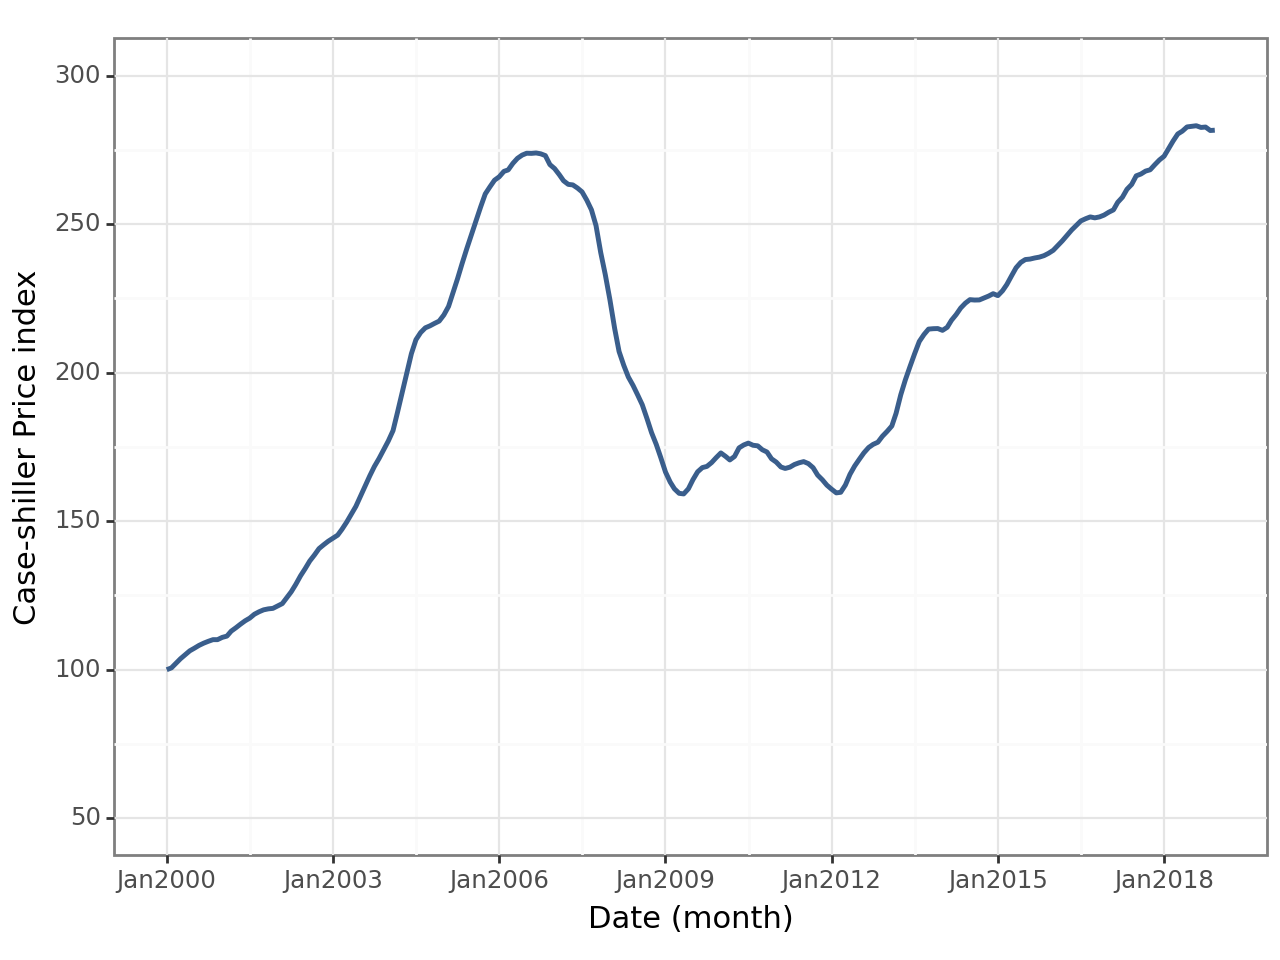

<Figure Size: (640 x 480)>

In [17]:
limits = datetime(2000, 1, 1), datetime(2019, 1, 1)
breaks = date_breaks("1 year")

price_index_plot = (
    ggplot(data, aes(x="date", y="p", group=1))
    + geom_line(color=color[0], size=1)
    + scale_y_continuous(limits=[50, 300], breaks=seq(50, 301, 50))
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Case-shiller Price index", x="Date (month)")
    + theme_bw()
)
price_index_plot

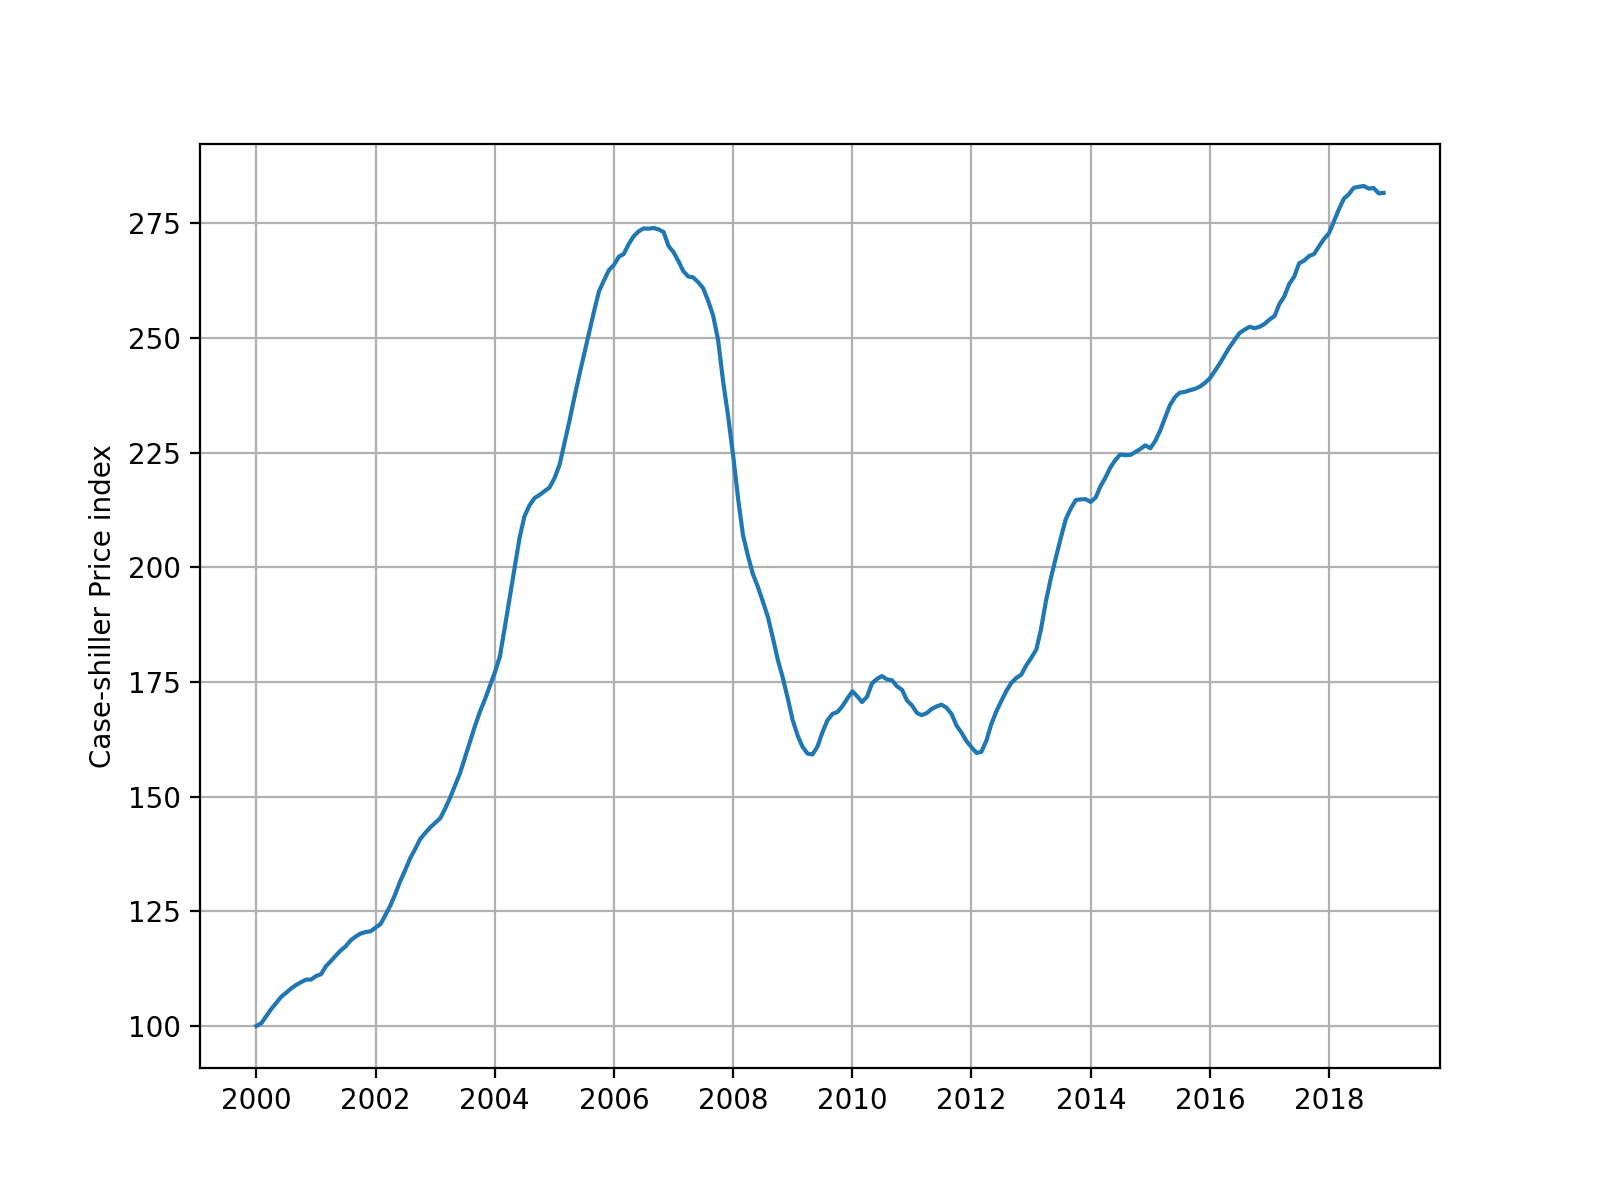

In [18]:
plt.subplots(figsize = (8,6))
plt.plot(pd.to_datetime(data.date), data.p)
plt.ylabel('Case-shiller Price index')
plt.grid(True);

**Log difference of price index**

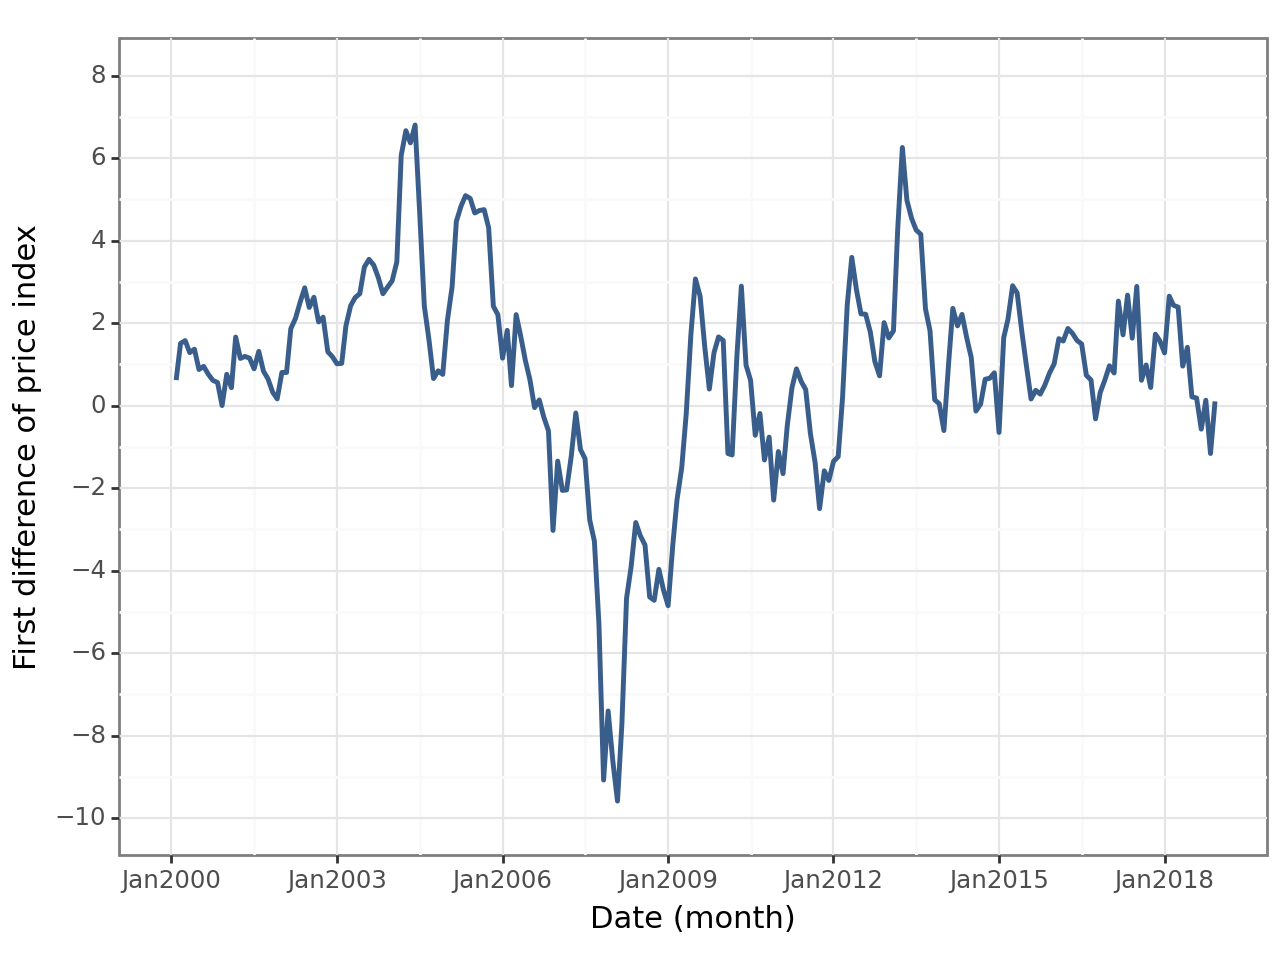

<Figure Size: (640 x 480)>

In [19]:
dp_plot = (
    ggplot(data, aes(x="date", y="dp", group=1))
    + geom_line(color=color[0], size=1)
    + scale_y_continuous(limits=[-10, 8], breaks=seq(-10, 9, 2))
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="First difference of price index", x="Date (month)")
    + theme_bw()
)
dp_plot

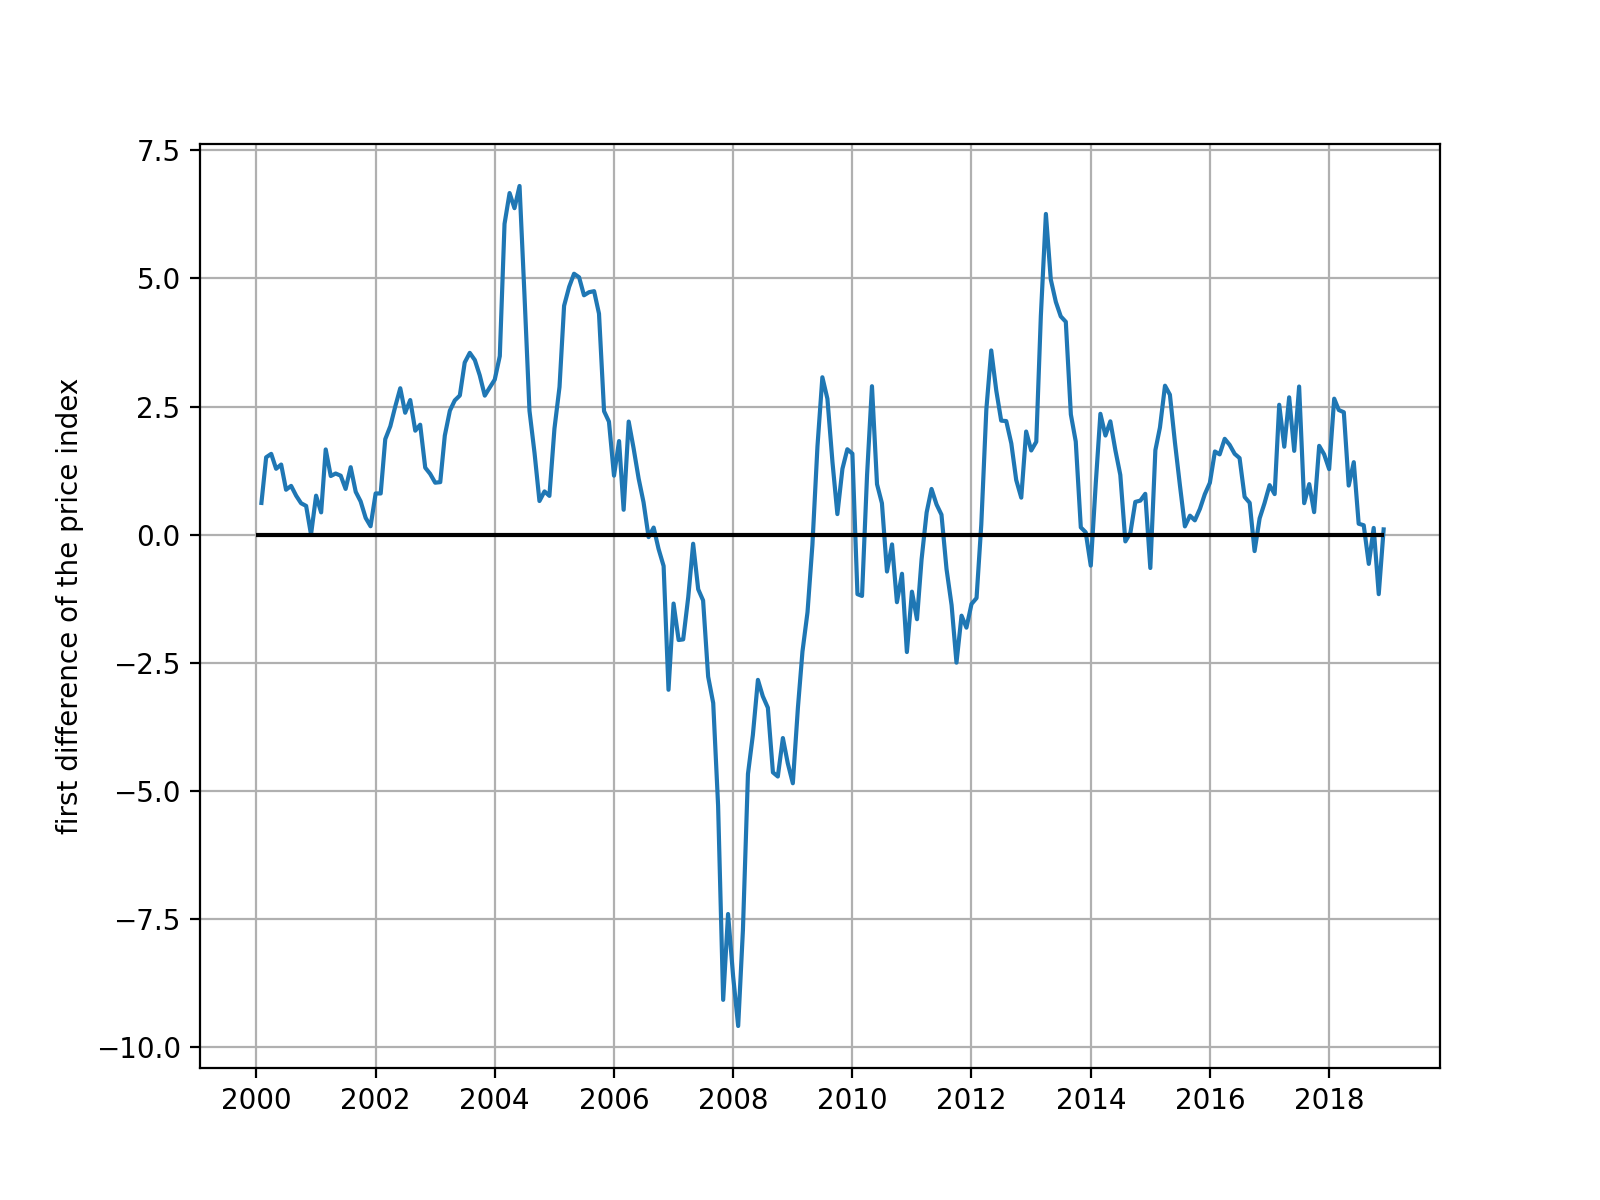

In [20]:
plt.subplots(figsize = (8,6))
plt.plot(pd.to_datetime(data.date), data.dp)
plt.ylabel('first difference of the price index')
plt.hlines(0, xmin = pd.to_datetime(data.date).min(), xmax = pd.to_datetime(data.date).max(), color = 'k')
plt.grid(True);

Log difference of price index

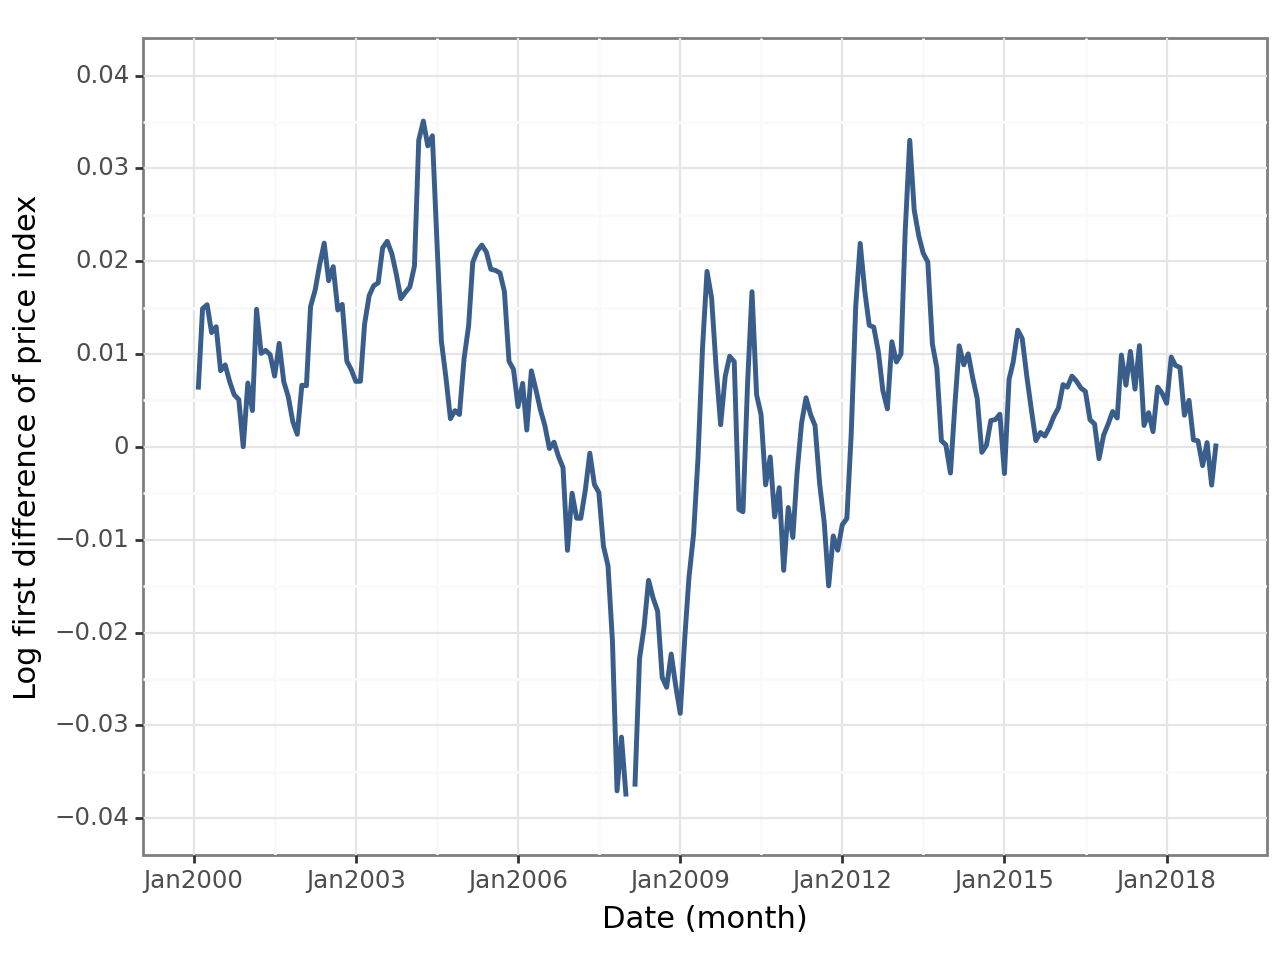

<Figure Size: (640 x 480)>

In [21]:
limits = datetime(2000, 1, 1), datetime(2018, 1, 1)
breaks = date_breaks("1 year")

dlnp_plot = (
    ggplot(data, aes(x="date", y="dlnp", group=1))
    + geom_line(color=color[0], size=1)
    + scale_y_continuous(limits=[-0.04, 0.04], breaks=seq(-0.04, 0.05, 0.01))
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Log first difference of price index", x="Date (month)")
    + theme_bw()
)
dlnp_plot

**Employment**

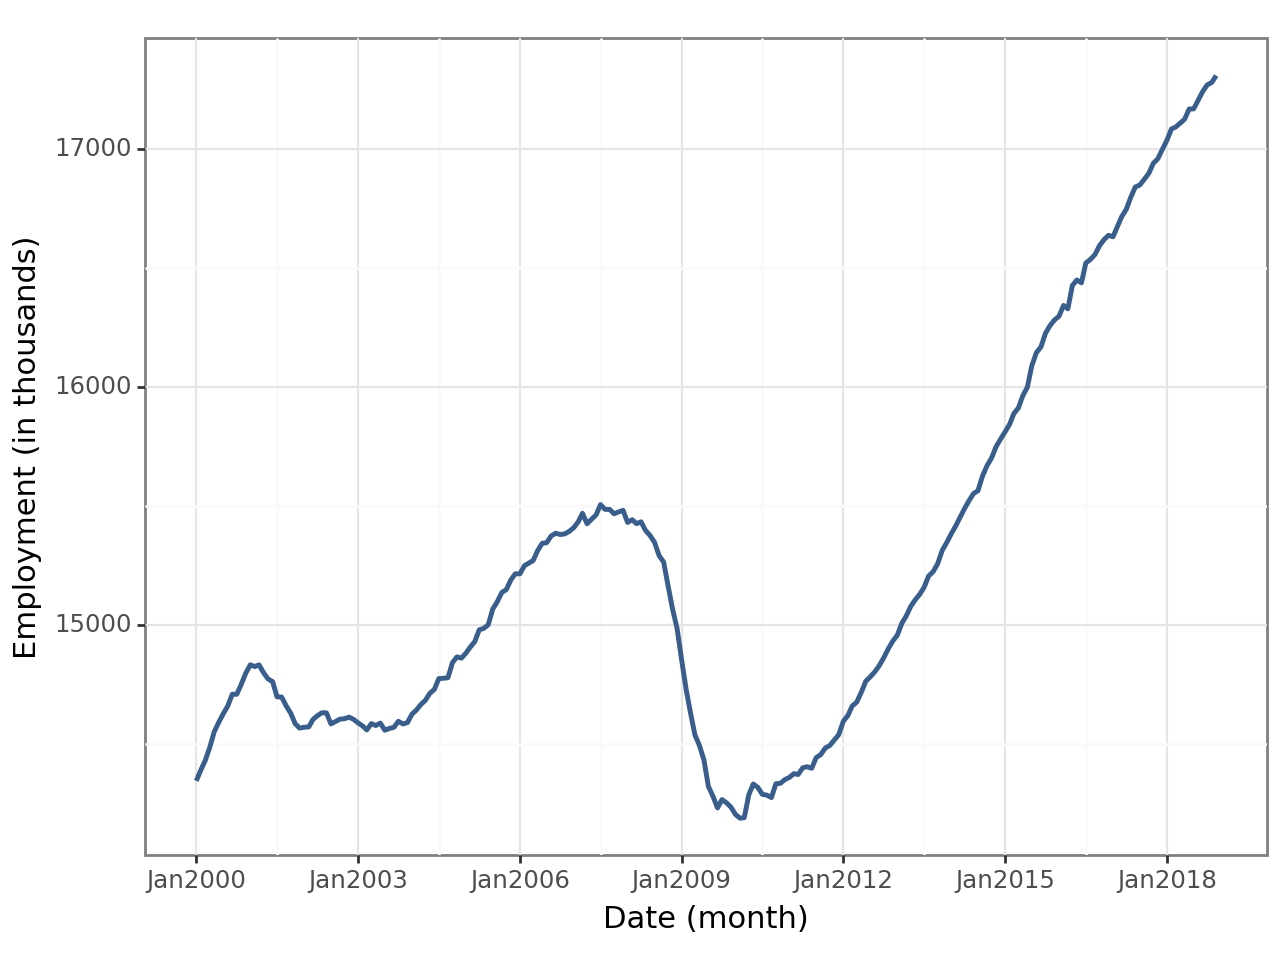

<Figure Size: (640 x 480)>

In [22]:
emp_plot = (
    ggplot(data, aes(x="date", y="emp", group=1))
    + geom_line(color=color[0], size=1)
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Employment (in thousands)", x="Date (month)")
    + theme_bw()
)
emp_plot

Log diff employment

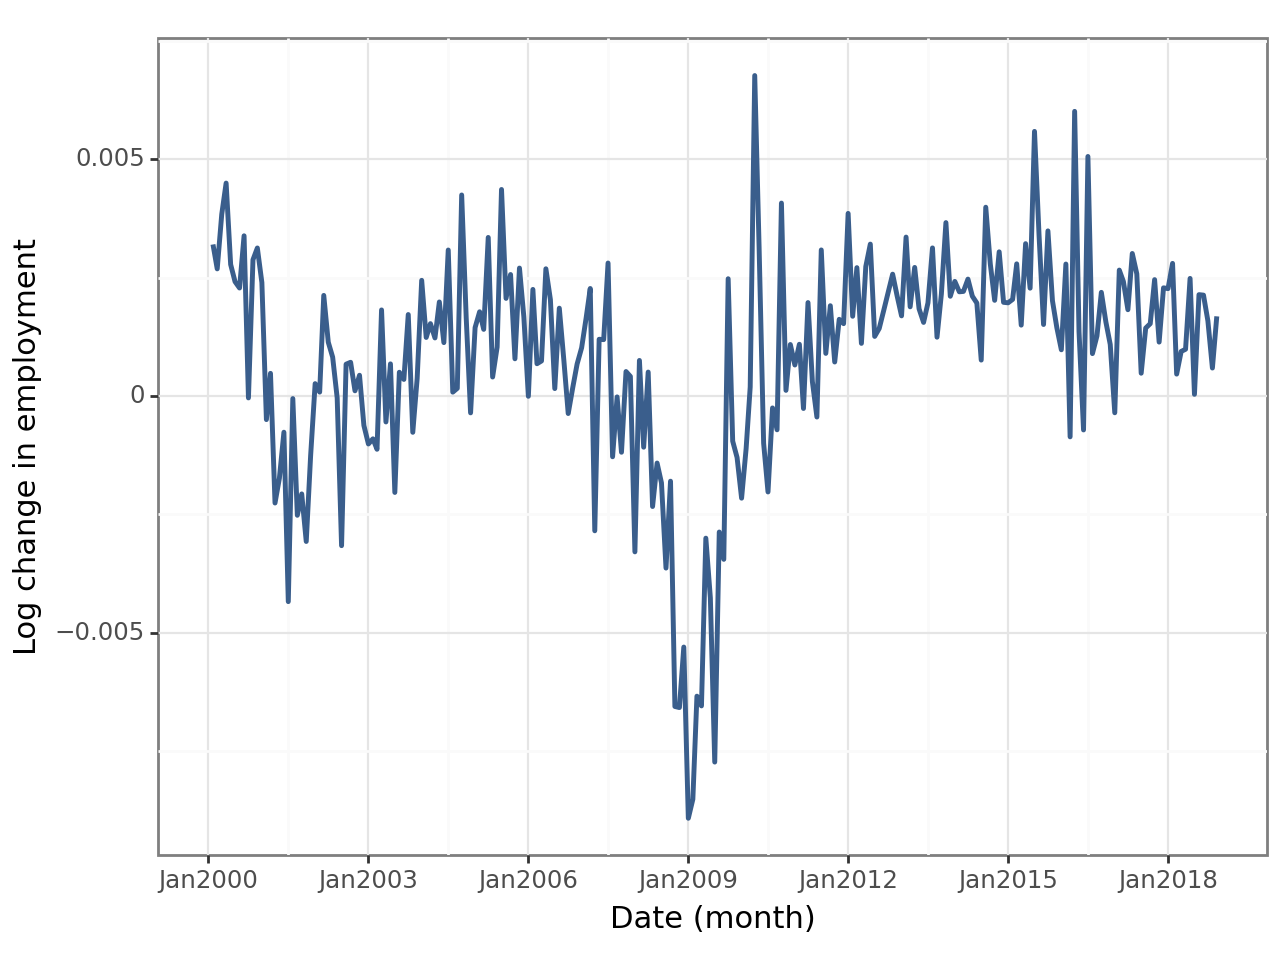

<Figure Size: (640 x 480)>

In [23]:
lnemp_plot = (
    ggplot(data, aes(x="date", y="dlnemp", group=1))
    + geom_line(color=color[0], size=1)
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Log change in employment", x="Date (month)")
    + theme_bw()
)

lnemp_plot

Unemployment rate

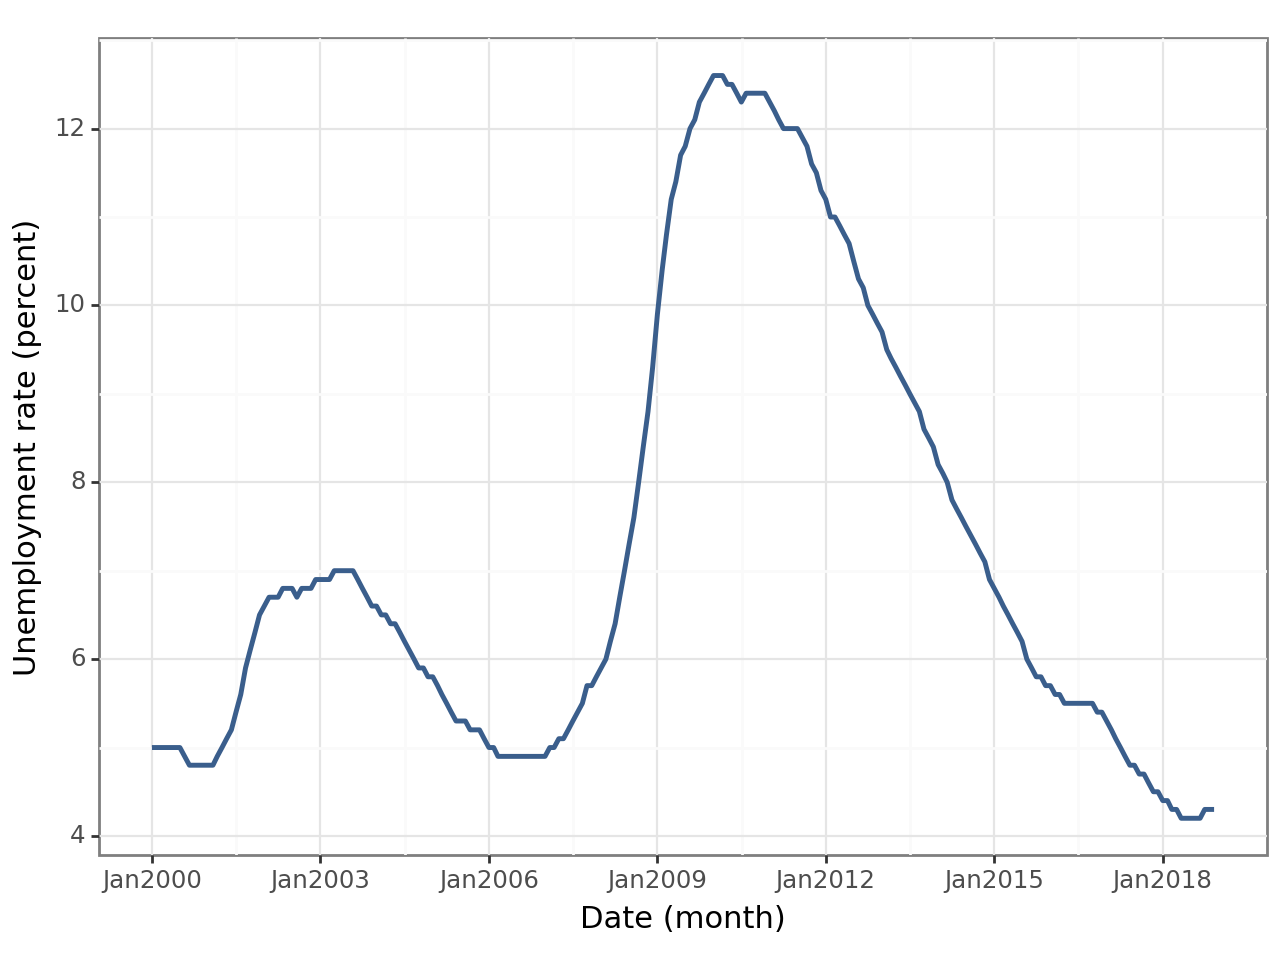

<Figure Size: (640 x 480)>

In [24]:
u_plot = (
    ggplot(data, aes(x="date", y="u", group=1))
    + geom_line(color=color[0], size=1)
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Unemployment rate (percent)", x="Date (month)")
    + theme_bw()
)

u_plot

Unemployment 1st diff

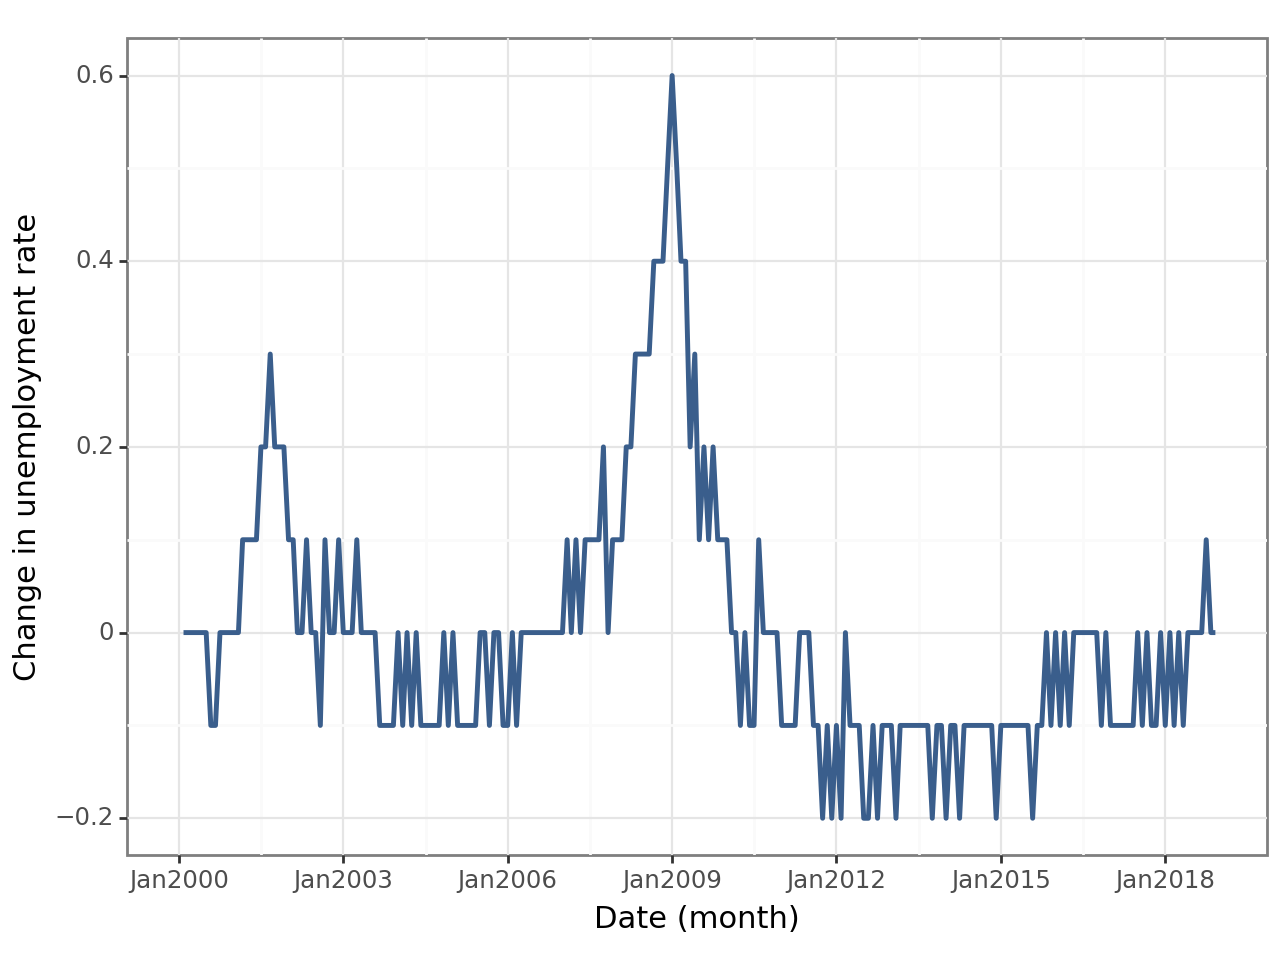

<Figure Size: (640 x 480)>

In [25]:
du_plot = (
    ggplot(data, aes(x="date", y="du", group=1))
    + geom_line(color=color[0], size=1)
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Change in unemployment rate", x="Date (month)")
    + theme_bw()
)

du_plot

### Create work set and holdout set

- we start after the [GFC](https://en.wikipedia.org/wiki/2007%E2%80%932008_financial_crisis)

In [26]:
data["date"] = pd.to_datetime(data["date"])

**create work and holdout sets**

In [27]:
data_holdout = data[data.year == 2018]
data_work = data[data.year < 2018]

**create training and test sets for 4 folds**

In [28]:
for year in range(2013, 2018):
    fold = year - 2012
    data_work["test" + str(fold)] = data_work["year"] == year
    data_work["train" + str(fold)] = (data_work["year"] <= year - 1) & (
        data_work["year"] >= year - 13
    )

In [29]:
data_work.columns

Index(['date', 'year', 'month', 'ps', 'p', 'u', 'un', 'emp', 'empn', 'dp',
       'p_lag', 'lnp', 'dlnp', 'lnp_lag', 'dlnp_lag', 'du', 'lnemp', 'dlnemp',
       'trend', 'test1', 'train1', 'test2', 'train2', 'test3', 'train3',
       'test4', 'train4', 'test5', 'train5'],
      dtype='object')

In [30]:
data_work[data_work.train1]

,date,year,month,ps,p,u,un,emp,empn,dp,...,test1,train1,test2,train2,test3,train3,test4,train4,test5,train5
0,2000-01-01,2000,1,101.031209,100.00000,5.0,5.4,14344.4,14132.8,NaN,...,False,True,False,False,False,False,False,False,False,False
1,2000-02-01,2000,2,102.043406,100.61896,5.0,5.3,14390.4,14270.0,0.61896,...,False,True,False,False,False,False,False,False,False,False
2,2000-03-01,2000,3,103.224699,102.12780,5.0,5.3,14429.1,14421.3,1.50884,...,False,True,False,False,False,False,False,False,False,False
3,2000-04-01,2000,4,104.159399,103.70410,5.0,4.7,14484.6,14450.8,1.57630,...,False,True,False,False,False,False,False,False,False,False
4,2000-05-01,2000,5,104.924698,104.98908,5.0,4.7,14549.9,14590.2,1.28498,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,2012-08-01,2012,8,170.649259,173.00625,10.3,10.6,14802.6,14737.5,2.21602,...,False,True,False,True,False,True,False,True,False,True
152,2012-09-01,2012,9,172.711556,174.78626,10.2,9.8,14829.4,14803.1,1.78001,...,False,True,False,True,False,True,False,True,False,True
153,2012-10-01,2012,10,174.790993,175.85370,10.0,9.8,14861.9,14945.7,1.06744,...,False,True,False,True,False,True,False,True,False,True
154,2012-11-01,2012,11,176.542913,176.57595,9.9,9.5,14900.2,15061.5,0.72225,...,False,True,False,True,False,True,False,True,False,True


In [31]:
data_work[data_work.test1]

,date,year,month,ps,p,u,un,emp,empn,dp,...,test1,train1,test2,train2,test3,train3,test4,train4,test5,train5
156,2013-01-01,2013,1,182.183984,180.22965,9.7,10.3,14957.2,14796.1,1.64208,...,True,False,False,True,False,True,False,True,False,True
157,2013-02-01,2013,2,184.874883,182.04080,9.5,9.8,15007.5,14921.8,1.81115,...,True,False,False,True,False,True,False,True,False,True
158,2013-03-01,2013,3,188.974529,186.30325,9.4,9.5,15035.8,14999.8,4.26245,...,True,False,False,True,False,True,False,True,False,True
159,2013-04-01,2013,4,193.855699,192.55935,9.3,8.8,15076.7,15065.0,6.25610,...,True,False,False,True,False,True,False,True,False,True
160,2013-05-01,2013,5,196.945168,197.53669,9.2,8.7,15104.5,15148.1,4.97734,...,True,False,False,True,False,True,False,True,False,True
161,2013-06-01,2013,6,200.333070,202.07630,9.1,9.4,15128.0,15178.6,4.53961,...,True,False,False,True,False,True,False,True,False,True
162,2013-07-01,2013,7,203.841451,206.33463,9.0,9.4,15157.8,15032.3,4.25833,...,True,False,False,True,False,True,False,True,False,True
163,2013-08-01,2013,8,207.929952,210.48633,8.9,9.0,15205.3,15145.7,4.15170,...,True,False,False,True,False,True,False,True,False,True
164,2013-09-01,2013,9,210.766271,212.83120,8.8,8.6,15224.2,15200.6,2.34487,...,True,False,False,True,False,True,False,True,False,True
165,2013-10-01,2013,10,213.689025,214.64741,8.6,8.6,15257.1,15344.3,1.81621,...,True,False,False,True,False,True,False,True,False,True


In [32]:
data_work[data_work.train2]

,date,year,month,ps,p,u,un,emp,empn,dp,...,test1,train1,test2,train2,test3,train3,test4,train4,test5,train5
12,2001-01-01,2001,1,112.031476,110.88080,4.8,5.3,14832.3,14619.9,0.76038,...,False,True,False,True,False,False,False,False,False,False
13,2001-02-01,2001,2,112.902899,111.31561,4.8,5.1,14824.9,14708.2,0.43481,...,False,True,False,True,False,False,False,False,False,False
14,2001-03-01,2001,3,114.178497,112.97801,4.9,5.3,14832.0,14826.3,1.66240,...,False,True,False,True,False,False,False,False,False,False
15,2001-04-01,2001,4,114.636796,114.12192,5.0,4.9,14798.5,14765.9,1.14391,...,False,True,False,True,False,False,False,False,False,False
16,2001-05-01,2001,5,115.257389,115.31479,5.1,4.6,14772.8,14815.0,1.19287,...,False,True,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2013-08-01,2013,8,207.929952,210.48633,8.9,9.0,15205.3,15145.7,4.15170,...,True,False,False,True,False,True,False,True,False,True
164,2013-09-01,2013,9,210.766271,212.83120,8.8,8.6,15224.2,15200.6,2.34487,...,True,False,False,True,False,True,False,True,False,True
165,2013-10-01,2013,10,213.689025,214.64741,8.6,8.6,15257.1,15344.3,1.81621,...,True,False,False,True,False,True,False,True,False,True
166,2013-11-01,2013,11,215.073784,214.78954,8.5,8.3,15313.1,15482.3,0.14213,...,True,False,False,True,False,True,False,True,False,True


In [33]:
data_work[data_work.test2]

,date,year,month,ps,p,u,un,emp,empn,dp,...,test1,train1,test2,train2,test3,train3,test4,train4,test5,train5
168,2014-01-01,2014,1,216.517630,214.231740,8.2,8.5,15382.6,15229.6,-0.604060,...,False,False,True,False,False,True,False,True,False,True
169,2014-02-01,2014,2,218.285035,215.249800,8.1,8.4,15416.5,15327.0,1.018060,...,False,False,True,False,False,True,False,True,False,True
170,2014-03-01,2014,3,220.125558,217.606990,8.0,8.4,15450.6,15410.7,2.357190,...,False,False,True,False,False,True,False,True,False,True
171,2014-04-01,2014,4,220.498567,219.540734,7.8,7.3,15488.8,15477.3,1.933744,...,False,False,True,False,False,True,False,True,False,True
172,2014-05-01,2014,5,220.835180,221.751634,7.7,7.3,15521.5,15564.0,2.210901,...,False,False,True,False,False,True,False,True,False,True
173,2014-06-01,2014,6,221.458649,223.396337,7.6,7.6,15552.0,15595.3,1.644703,...,False,False,True,False,False,True,False,True,False,True
174,2014-07-01,2014,7,222.042717,224.562593,7.5,8.0,15563.8,15436.0,1.166256,...,False,False,True,False,False,True,False,True,False,True
175,2014-08-01,2014,8,222.097467,224.431052,7.4,7.7,15626.0,15573.6,-0.131541,...,False,False,True,False,False,True,False,True,False,True
176,2014-09-01,2014,9,222.782099,224.468392,7.3,7.1,15669.7,15645.4,0.037341,...,False,False,True,False,False,True,False,True,False,True
177,2014-10-01,2014,10,224.501650,225.107593,7.2,6.9,15701.4,15799.9,0.639200,...,False,False,True,False,False,True,False,True,False,True


### Modelling

In [34]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR

**Model M1: OLS on trend & seasonality**

In [35]:
mse_1 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model1 = smf.ols("p ~ trend + C(month)", train_data).fit()

    phat = model1.predict(test_data)

    errsq = np.square(test_data.p.values - phat)

    mse_1.append(np.mean(errsq))

rmse_cv_m1 = np.sqrt(np.mean(mse_1))

**Model M2: p ARIMA(1,1,2)**

- get order from auto_arima

In [36]:
auto_arima_m2 = auto_arima(
    y = data_work.p,
    start_p = 0,
    max_p = 1,  # without this constrain, python returns a higher AR order
    # max_order=0,
    seasonal = False
)

mse_2 = []

for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model2 = ARIMA(train_data.p, order=auto_arima_m2.get_params()["order"]).fit()

    phat = model2.forecast(steps=12)

    errsq = np.square(test_data.p.values - phat)

    mse_2.append(np.mean(errsq))

rmse_cv_m2 = np.sqrt(np.mean(mse_2))

In [37]:
rmse_cv_m2

9.478036330328777

In [38]:
auto_arima_m2.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 1, 2),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

**Model M3: p ARIMA(1,1,0)**

- get order from auto_arima

How to create dummies with Pandas

In [39]:
pd.get_dummies(data_work.month).iloc[0:12]

,1,2,3,4,5,6,7,8,9,10,11,12
0,True,False,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,False,False
5,False,False,False,False,False,True,False,False,False,False,False,False
6,False,False,False,False,False,False,True,False,False,False,False,False
7,False,False,False,False,False,False,False,True,False,False,False,False
8,False,False,False,False,False,False,False,False,True,False,False,False
9,False,False,False,False,False,False,False,False,False,True,False,False


In the backend caluclations `numpy` cannot correctly handle booleans, so a type conversion is necessary.

In [40]:
pd.get_dummies(data_work.month).iloc[0:12].astype(int)

,1,2,3,4,5,6,7,8,9,10,11,12
0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,0,0
8,0,0,0,0,0,0,0,0,1,0,0,0
9,0,0,0,0,0,0,0,0,0,1,0,0


In [41]:
auto_arima_m3 = auto_arima(
    y = data_work.p, 
    X = pd.get_dummies(data_work.month).astype(int), 
    seasonal = False
)

In [42]:
auto_arima_m3.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (4, 1, 3),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [43]:
mse_3 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model3 = ARIMA(
        train_data.p,
        exog=pd.get_dummies(train_data.month),
        order=auto_arima_m3.get_params()["order"],
    ).fit()

    phat = model3.forecast(steps=12, exog=pd.get_dummies(test_data.month))

    errsq = np.square(test_data.p.values - phat)

    mse_3.append(np.mean(errsq))

rmse_cv_m3 = np.sqrt(np.mean(mse_3))

In [44]:
rmse_cv_m3

3.6709669881189813

**Model M4: p ARIMA(2,0,0) + seasonality + trend**

In [45]:
X = pd.get_dummies(data_work.month).astype(int)
X.columns = [str(x) for x in X.columns] # we need to convert numerical colnames to str as pmdarima cannot handle column names of mixed types
X['trend'] = data_work.trend
X

,1,2,3,4,5,6,7,8,9,10,11,12,trend
0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,0,0,2
2,0,0,1,0,0,0,0,0,0,0,0,0,3
3,0,0,0,1,0,0,0,0,0,0,0,0,4
4,0,0,0,0,1,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,0,0,0,0,0,0,0,1,0,0,0,0,212
212,0,0,0,0,0,0,0,0,1,0,0,0,213
213,0,0,0,0,0,0,0,0,0,1,0,0,214
214,0,0,0,0,0,0,0,0,0,0,1,0,215


In [46]:
auto_arima_m4 = auto_arima(
    y = data_work.p,
    X = X,
    seasonal = False,
)

In [47]:
auto_arima_m4.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (3, 0, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [48]:
mse_4 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model4 = ARIMA(
        train_data.p,
        exog = pd.get_dummies(train_data.month).astype(int),
        trend = 't', # 't' stands for a linear term
        order = auto_arima_m4.get_params()["order"],
    ).fit()

    phat = model4.forecast(steps=12, exog=pd.get_dummies(test_data.month), trend="t")

    errsq = np.square(test_data.p.values - phat)

    mse_4.append(np.mean(errsq))

rmse_cv_m4 = np.sqrt(np.mean(mse_4))

In [49]:
rmse_cv_m4

2.143324401610368

**Model M5: dp ~ month + trend, without any ARIMA**

In [50]:
mse_5 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model5 = smf.ols("dp ~ trend + C(month)", train_data).fit()

    dphat = model5.predict(test_data)

    test_data["phat"] = None
    
    for i in range(0, 12):
        if i == 0:
            test_data.iloc[i, -1] = train_data["p"].values[-1] + dphat.iloc[i]
        else:
            test_data.iloc[i, -1] = test_data.iloc[i - 1, -1] + dphat.iloc[i]

    errsq = np.square(test_data["p"] - test_data["phat"])

    mse_5.append(np.mean(errsq))

rmse_cv_m5 = np.sqrt(np.mean(mse_5))

In [51]:
rmse_cv_m5

18.78202953776931

**Model M6: lnp ARIMA(0,2,0) + built-in seasonality using `auto_arima`**

In [52]:
auto_arima_m6 = auto_arima(
    y = data_work.lnp,
    d = 2,  # without this constrain, python returns other ARIMA order
    seasonal=True,
    m = 12
)

In [53]:
auto_arima_m6.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 2, 2),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 0, 0, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [54]:
mse_6 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model6 = ARIMA(
        train_data.lnp,
        # exog=pd.get_dummies(train_data.month),
        order=auto_arima_m6.get_params()["order"],
    ).fit()

    lnphat = model6.forecast(steps=12, exog=pd.get_dummies(test_data.month))

    corrb = mean_squared_error(test_data.lnp, lnphat)

    phat = np.exp((lnphat + corrb / 2))

    errsq = np.square(test_data.p.values - phat)

    mse_6.append(np.mean(errsq))

rmse_cv_m6 = np.sqrt(np.mean(mse_6))

In [55]:
rmse_cv_m6

6.0161425056535185

**Vector Autoregression**

In [56]:
mse_var = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1, :].dropna()
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1, :].dropna()

    model7 = VAR(train_data[["dp", "du", "dlnemp"]]).fit(1)

    dphat = model7.forecast(
        train_data[["dp", "du", "dlnemp"]].values[-model7.k_ar :], steps=12
    )[:, 0]

    test_data["phat"] = None
    for i in range(0, 12):
        if i == 0:
            test_data.iloc[i, -1] = train_data["p"].values[-1] + dphat[i]
        else:
            test_data.iloc[i, -1] = test_data.iloc[i - 1, -1] + dphat[i]

    errsq = np.square(test_data["p"] - test_data["phat"])

    mse_var.append(np.mean(errsq))

rmse_cv_m7 = np.sqrt(np.mean(mse_var))

In [57]:
rmse_cv_m7

8.034694282539114

#### Summary

*Note: some model's cv rmse differns from textbook*

In [58]:
pd.DataFrame(
    [mse_1, mse_2, mse_3, mse_4, mse_5, mse_6, mse_var],
    columns=["Fold" + str(i) for i in range(1, 5)],
).apply(np.sqrt).assign(
    Average=[
        rmse_cv_m1,
        rmse_cv_m2,
        rmse_cv_m3,
        rmse_cv_m4,
        rmse_cv_m5,
        rmse_cv_m6,
        rmse_cv_m7,
    ],
    model=["M" + str(i) for i in range(1, 7)] + ["M7 (var)"],
).round(
    2
).set_index(
    "model"
)

,Fold1,Fold2,Fold3,Fold4,Average
model,,,,,
M1,14.90,17.59,34.43,48.58,31.93
M2,14.82,8.39,6.23,5.53,9.48
M3,5.54,2.28,1.36,4.02,3.67
M4,3.09,1.33,1.77,1.97,2.14
M5,33.94,9.79,10.42,7.39,18.78
M6,7.84,7.68,3.82,3.11,6.02
M7 (var),13.90,6.33,3.40,3.63,8.03


### Predict for holdout

**The best model is M4.**

In [59]:
auto_arima_m4.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (3, 0, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

- What's inside the model?

In [60]:
print(auto_arima_m4.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  216
Model:               SARIMAX(3, 0, 1)   Log Likelihood                -272.075
Date:                Mon, 12 Feb 2024   AIC                            580.149
Time:                        17:57:05   BIC                            640.905
Sample:                             0   HQIC                           604.695
                                - 216                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
1            144.1133     29.530      4.880      0.000      86.235     201.992
2            143.2891     29.546      4.850      0.000      85.380     201.199
3            143.4839     29.552      4.855      0.0

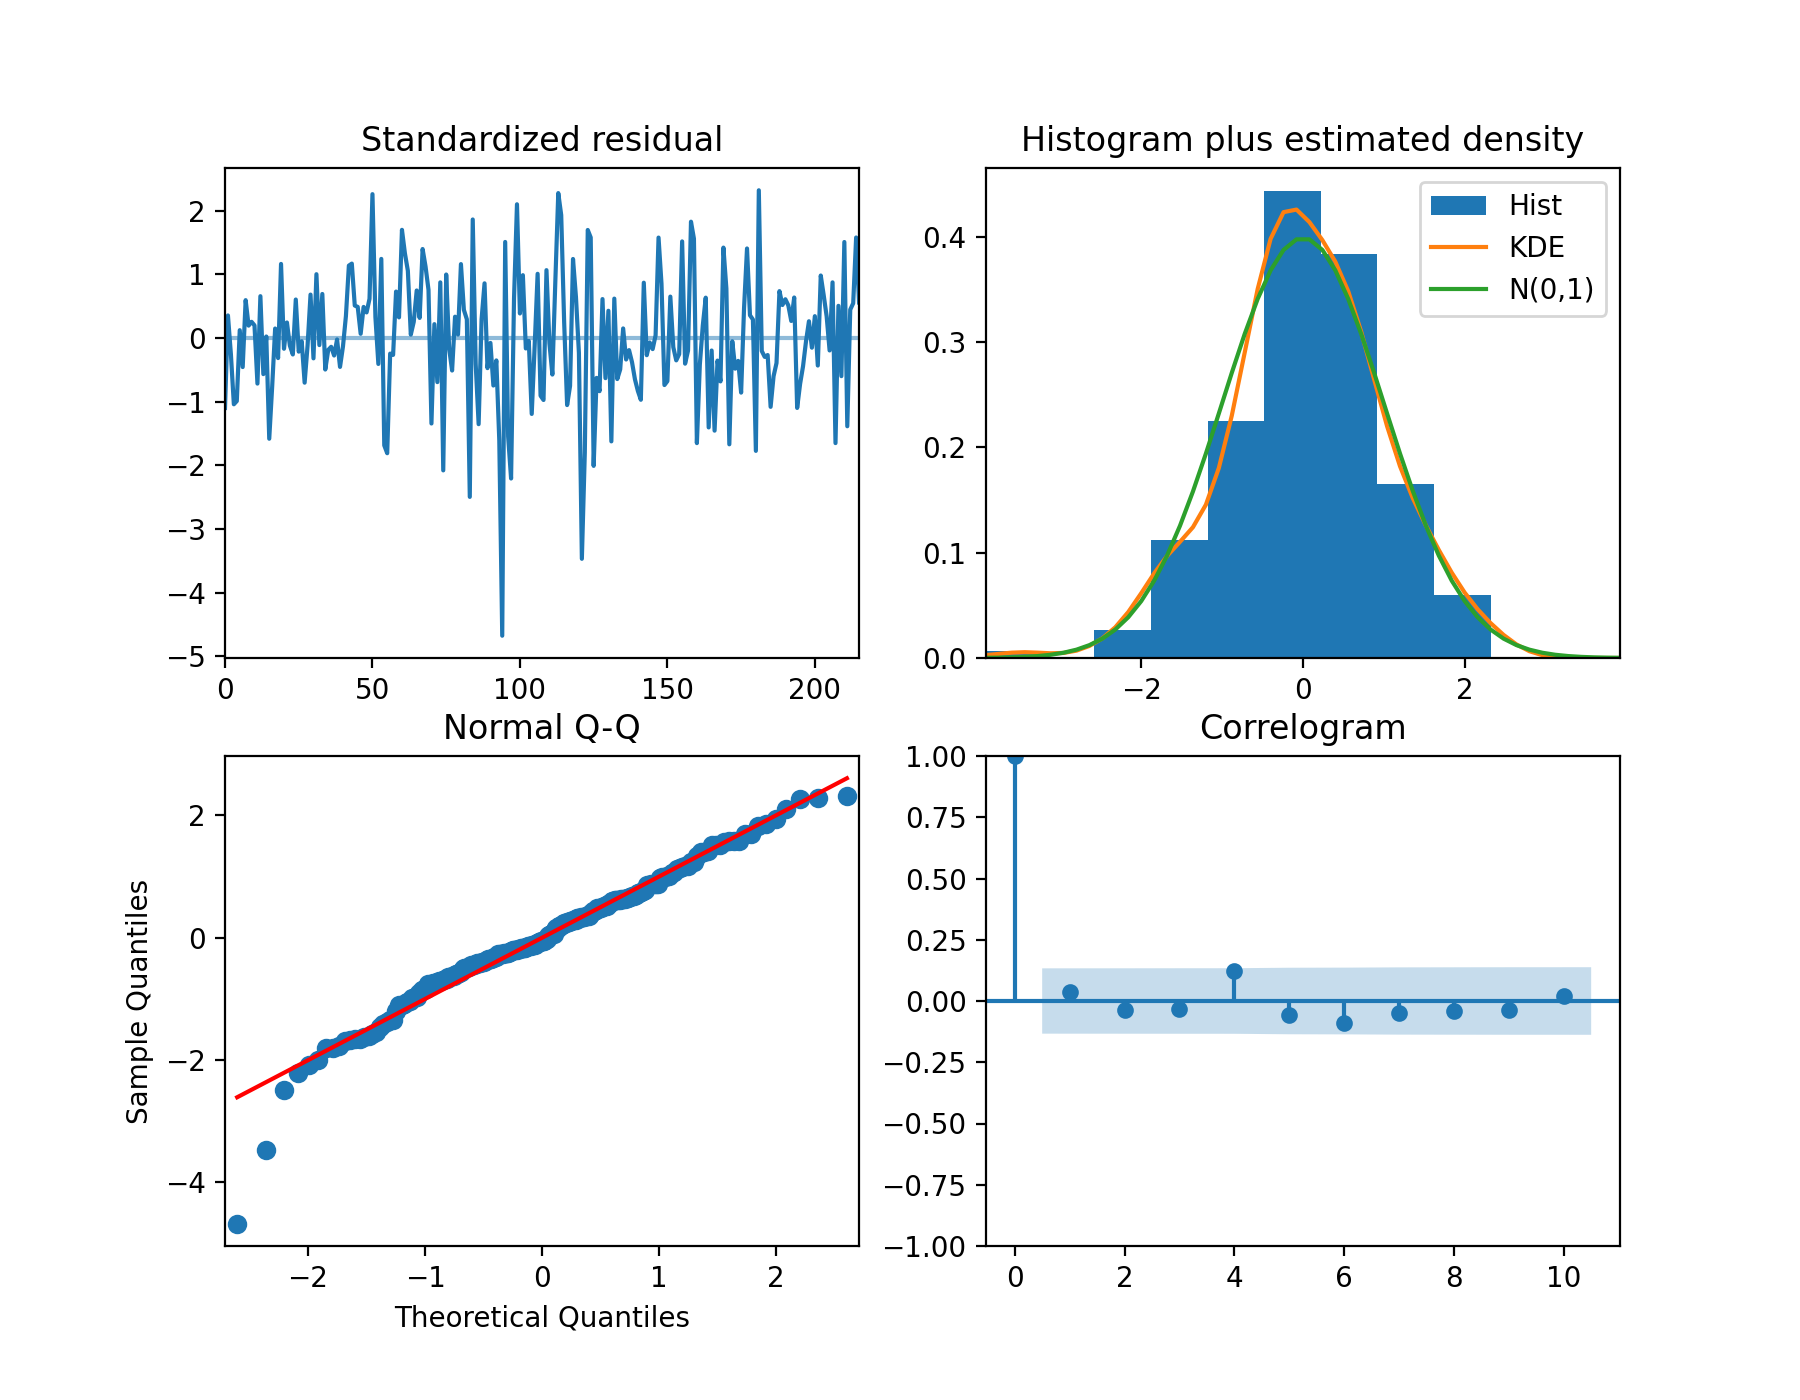

In [61]:
auto_arima_m4.plot_diagnostics(figsize = (9,7));

- Re-estimate best models on full work set

In [62]:
model_final = ARIMA(
    data_work.p, 
    exog = pd.get_dummies(data_work.month).astype(int), 
    trend = "t", 
    order = auto_arima_m4.get_params()["order"]
).fit()

In [63]:
print(model_final.summary())

                               SARIMAX Results                                
Dep. Variable:                      p   No. Observations:                  216
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -272.075
Date:                Mon, 12 Feb 2024   AIC                            580.150
Time:                        17:57:06   BIC                            640.905
Sample:                             0   HQIC                           604.695
                                - 216                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.5218      0.233      2.235      0.025       0.064       0.979
1            144.1134     29.524      4.881      0.000      86.248     201.979
2            143.2891     29.540      4.851      0.0

In [64]:
pred_final = model_final.get_forecast(
    steps=12, 
    exog = pd.get_dummies(data_holdout.month).astype(int),
    trend="t"
)

In [65]:
data_holdout

,date,year,month,ps,p,u,un,emp,empn,dp,p_lag,lnp,dlnp,lnp_lag,dlnp_lag,du,lnemp,dlnemp,trend
216,2018-01-01,2018,1,274.775958,272.857728,4.4,4.8,17037.0,16867.4,1.278135,271.579593,5.608951,0.004695,5.604255,0.005793,-0.1,9.743143,0.002268,217
217,2018-02-01,2018,2,277.381439,275.510646,4.4,4.7,17084.8,16996.2,2.652918,272.857728,5.618626,0.009676,5.608951,0.004695,0.0,9.745944,0.002802,218
218,2018-03-01,2018,3,278.653962,277.942479,4.3,4.5,17092.7,17047.5,2.431833,275.510646,5.627414,0.008788,5.618626,0.009676,-0.1,9.746407,0.000462,219
219,2018-04-01,2018,4,279.873657,280.330541,4.3,4.1,17108.8,17086.9,2.388062,277.942479,5.635969,0.008555,5.627414,0.008788,0.0,9.747348,0.000941,220
220,2018-05-01,2018,5,280.259290,281.288374,4.2,3.7,17125.7,17146.7,0.957833,280.330541,5.639380,0.003411,5.635969,0.008555,-0.1,9.748336,0.000987,221
221,2018-06-01,2018,6,281.028441,282.702167,4.2,4.4,17168.3,17202.0,1.413792,281.288374,5.644394,0.005014,5.639380,0.003411,0.0,9.750820,0.002484,222
222,2018-07-01,2018,7,281.455570,282.915360,4.2,4.5,17168.9,17040.4,0.213193,282.702167,5.645148,0.000754,5.644394,0.005014,0.0,9.750855,0.000035,223
223,2018-08-01,2018,8,281.894600,283.099199,4.2,4.4,17205.7,17149.1,0.183839,282.915360,5.645797,0.000650,5.645148,0.000754,0.0,9.752996,0.002141,224
224,2018-09-01,2018,9,281.932828,282.529321,4.2,3.9,17242.4,17199.3,-0.569878,283.099199,5.643782,-0.002015,5.645797,0.000650,0.0,9.755127,0.002131,225
225,2018-10-01,2018,10,282.684714,282.660549,4.3,4.0,17269.8,17371.5,0.131228,282.529321,5.644247,0.000464,5.643782,-0.002015,0.1,9.756715,0.001588,226


In [66]:
forecast_holdout_best = (
    data_holdout.assign(
        p_pred = pred_final.predicted_mean.values, 
        model="best")
    .join(pred_final.conf_int(alpha=0.2))
    .filter(["model", "p_pred", "lower p", "upper p"])
)

In [67]:
forecast_holdout_best

,model,p_pred,lower p,upper p
216,best,273.341031,272.274295,274.407766
217,best,274.843509,272.606740,277.080277
218,best,277.394664,273.735320,281.054009
219,best,280.424585,275.228332,285.620837
220,best,283.765030,276.898395,290.631664
221,best,286.603531,278.005673,295.201389
222,best,289.156458,278.757393,299.555523
223,best,290.811225,278.585780,303.036669
224,best,292.016404,277.935858,306.096951
225,best,292.467527,276.532769,308.402286


In [68]:
data_plot = data.join(forecast_holdout_best).loc[lambda x: x.year >= 2015]

In [69]:
data_plot_1 = pd.melt(data_plot[["date","p","p_pred"]],["date"])

In [70]:
data_plot_1

,date,variable,value
0,2015-01-01,p,225.918596
1,2015-02-01,p,227.566305
2,2015-03-01,p,229.656980
3,2015-04-01,p,232.562612
4,2015-05-01,p,235.292393
...,...,...,...
91,2018-08-01,p_pred,290.811225
92,2018-09-01,p_pred,292.016404
93,2018-10-01,p_pred,292.467527
94,2018-11-01,p_pred,292.610832


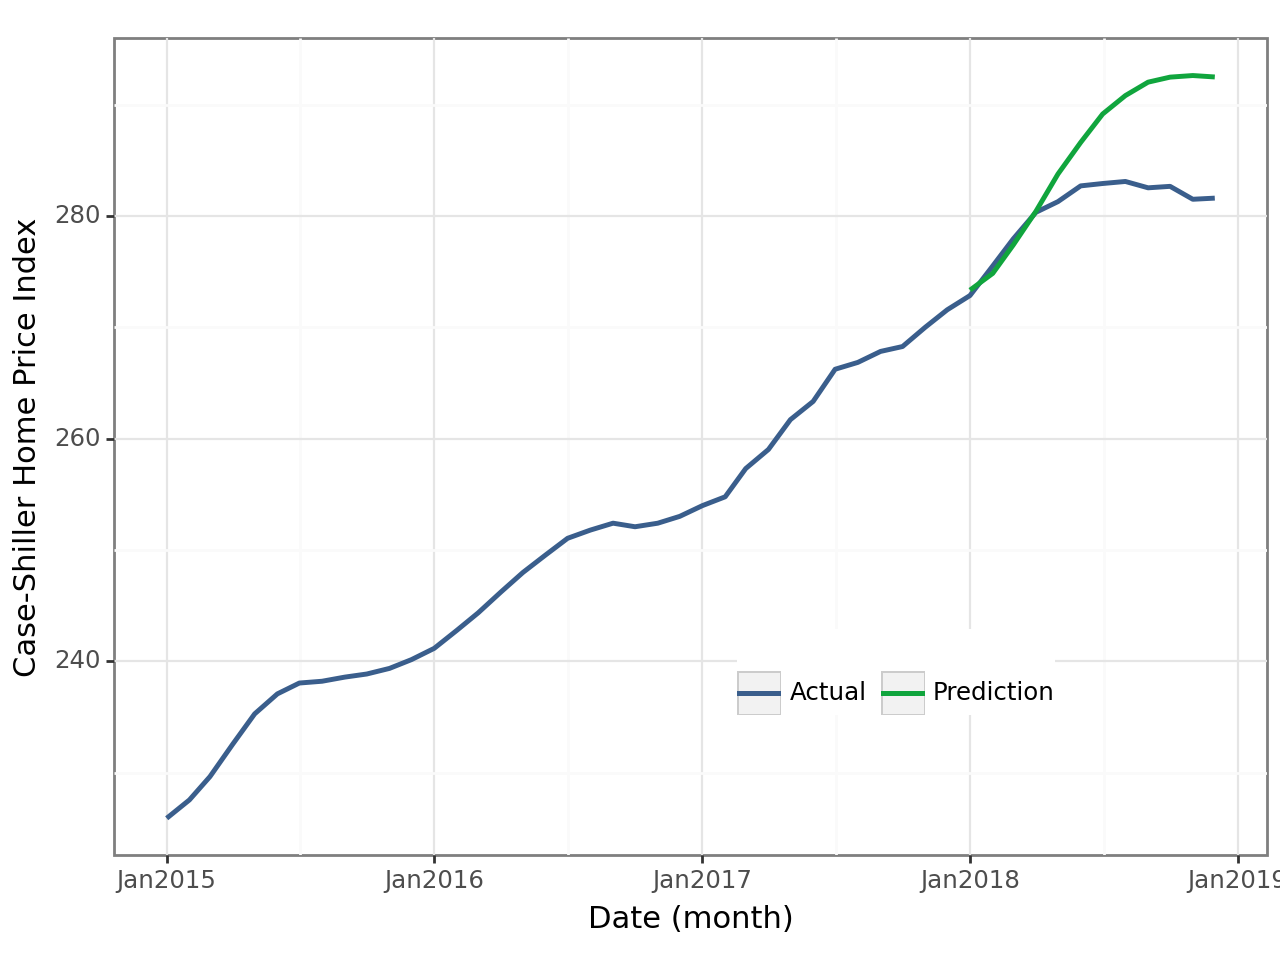

<Figure Size: (640 x 480)>

In [71]:
pred_p_plot = (
    ggplot(data_plot_1, aes(x="date", y="value", color="variable"))
    + geom_line(size=1)
    + ylab("Case-Shiller Home Price Index")
    + xlab("Date (month)")
    + scale_color_manual(
        name=" ", values=(color[0], color[1]), labels=("Actual", "Prediction")
    )
    + scale_x_date(date_breaks="1 years", labels=date_format("%b%Y"))
    + theme_bw()
    + theme(legend_position=(0.7, 0.3), legend_direction="horizontal")
)
pred_p_plot

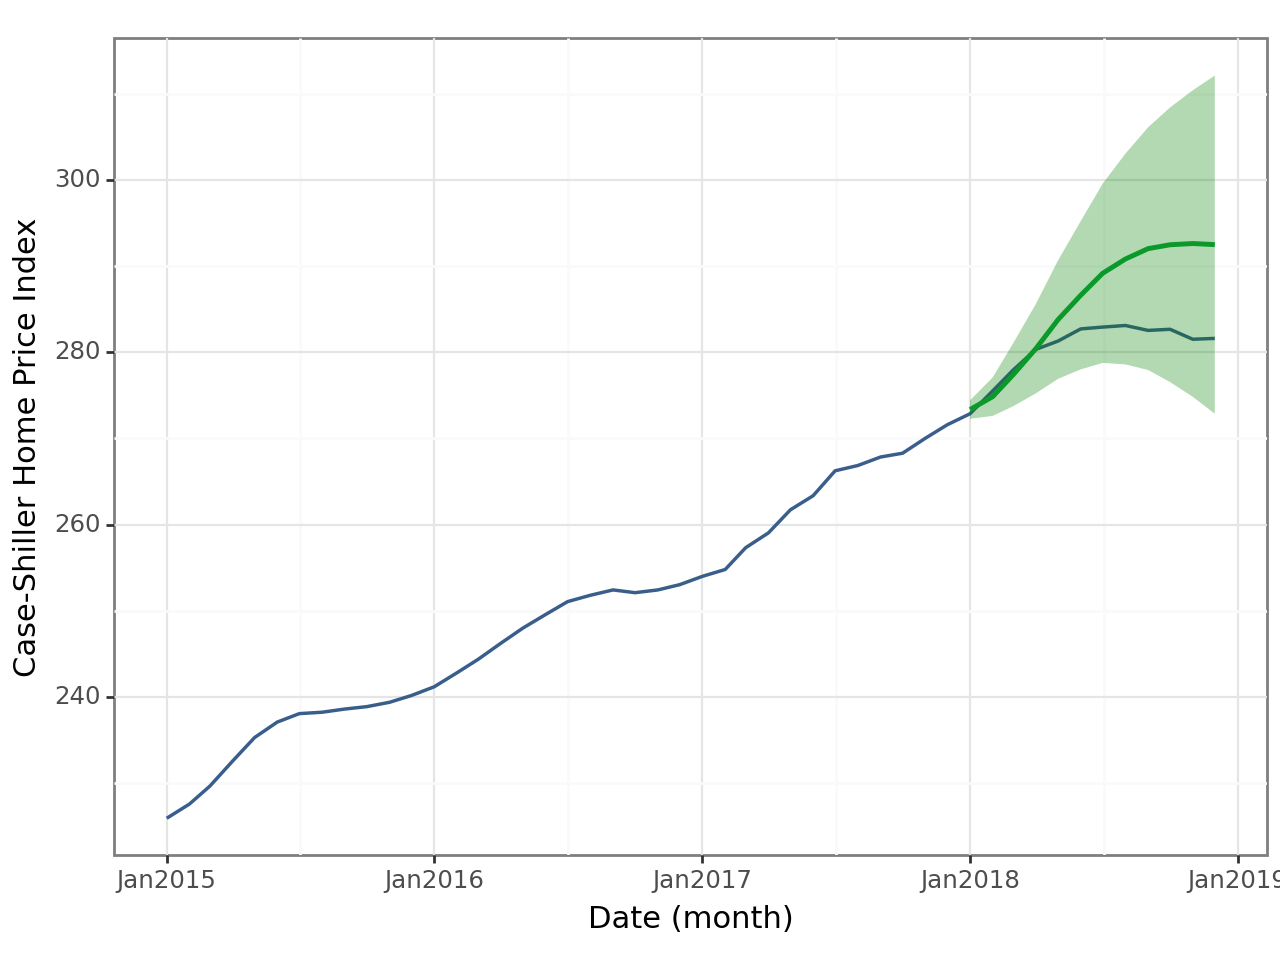

<Figure Size: (640 x 480)>

In [72]:
pred_p_plot = (
    ggplot(data_plot, aes(x="date"))
    + geom_line(aes(y="p"), color=color[0], size=0.7)
    + geom_line(aes(y="p_pred"), color=color[1], size=1)
    + geom_line(aes(y="lower p"), color=color[1], size=0)
    + geom_line(aes(y="upper p"), color=color[1], size=0)
    + geom_ribbon(aes(ymin="lower p", ymax="upper p"), fill="green", alpha=0.3)
    + ylab("Case-Shiller Home Price Index")
    + xlab("Date (month)")
    + theme_bw()
    + scale_x_date(date_breaks="1 years", labels=date_format("%b%Y"))
)
pred_p_plot

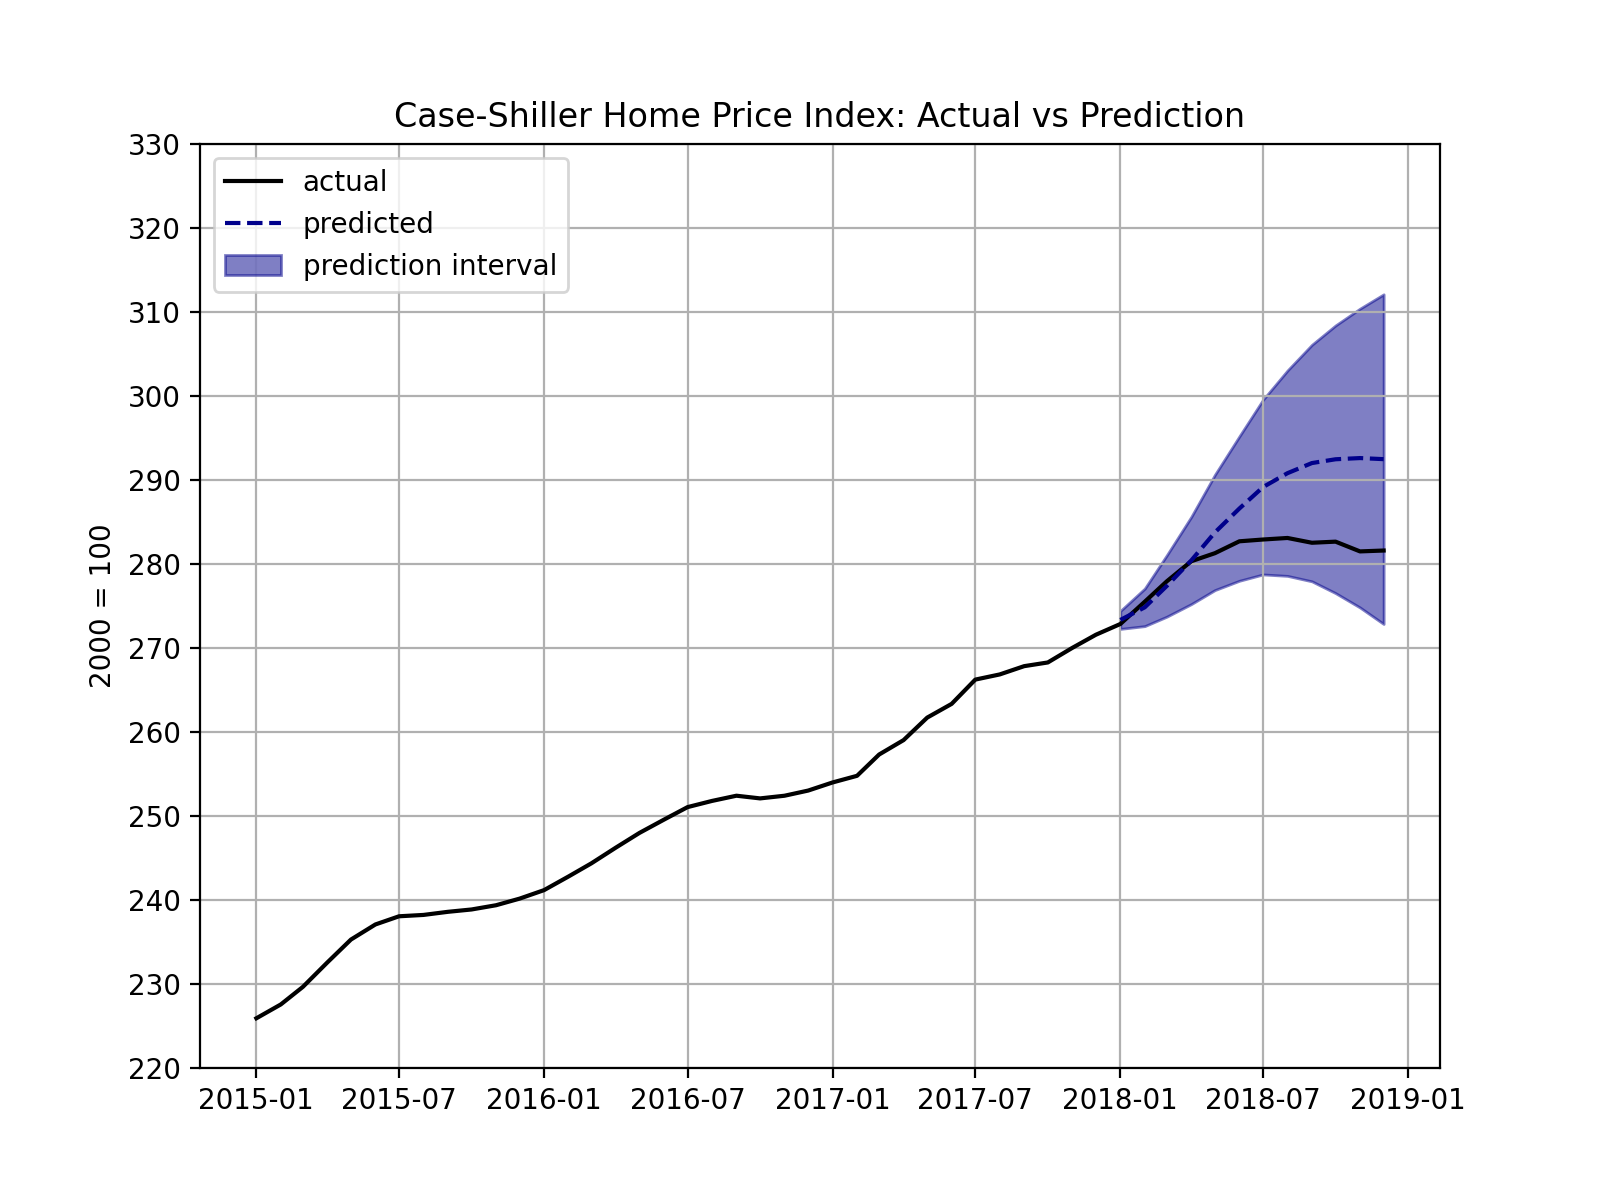

In [73]:
plt.subplots(figsize = (8,6))
plt.plot(data_plot.date, data_plot.p, color = 'k')
plt.plot(data_plot.date, data_plot.p_pred, color = 'darkblue', linestyle = '--')
plt.fill_between(data_plot.date, data_plot['lower p'], data_plot['upper p'], color = 'darkblue', alpha = 0.5)
plt.legend(['actual', 'predicted', 'prediction interval'], loc = 'upper left')
plt.ylabel('2000 = 100')
plt.grid(True)
plt.yticks(range(220,340,10))
plt.title('Case-Shiller Home Price Index: Actual vs Prediction');

In [74]:
errsq = np.square(data_holdout.p.values - forecast_holdout_best.p_pred)

rmse_holdout = np.mean(errsq)
rmse_holdout

45.72884968315845